# Baseline Model
As a simple model for this binary prediction, we choose logistic regression. This is both a conceptually simple and easy to interpret model, and can be extended to include more classes if necessary.

In this logistic regression model, we have to preprocess the data. For categorical variables this means creating dummy variables and for continuous variables, it means centering and scaling the data by the mean and standard deviation respectively. Many solvers that are optimized for large datasets perfrom better when the variables have similar ranges.

Then we get rid of variables involving arbitrary dates, such as date that the survey was administered, or the student's birth date. These will be difficult to handle in a logistic regression context. Variables such as 'parent's birth year' should work fine, as it is a single number.

In [1]:
#import relevant packages
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import re
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
%matplotlib inline

In [2]:
#import student data from wrangling stage
filepath = '/Users/chrismalec/DS_Portfolio/CapstoneProjectOne/'
df_BY = pd.read_pickle(filepath + 'df_BY.pkl')
df_F3 = pd.read_pickle(filepath + 'df_F3.pkl')
df_weights = pd.read_pickle(filepath + 'df_weights.pkl')
labels = pd.read_pickle(filepath + 'labels.pkl')
alt_labels = df_F3['X4EVERDROP']

import pickle
pickle_in = open(filepath+'number_labels.pkl',"rb")
number_labels = pickle.load(pickle_in)

In [3]:
#Create two groups of variables: continuous and discrete
cont_var = []
disc_var = []
for key in df_BY.columns:
    if list(number_labels[key].keys()) == ['desc']:
        cont_var.append(key)
    elif 'desc' not in list(number_labels[key].keys()):
        continue
    else:
        disc_var.append(key)
        
print('There are %f continuous variables and %f discrete variables' 
      %(len(cont_var),len(disc_var)))

There are 100.000000 continuous variables and 937.000000 discrete variables


In [4]:
#Fixing cont_var
cont_var = [x for x in cont_var if not re.search("YYYYMM",number_labels[x]['desc'])]
Student_ID = cont_var.pop(0)

## Handling missing data

At this point, there is not much missing data, but there are several different codes that refer to missing data. We will refer to most of these codes as nan, however non-response data is left as '-8' for discrete variables, as this represents a distinct category from the other types of missing data. All missing codes are converted to nan for continuous variables, as the values of the missing data can throw off the mean and standard deviations by quite a bit.

In [5]:
#-4 means a follow through missing, 
#-5 is suppressed in public use data and was already cleaned,
#-6 is an abbreviated interview, 
#-7 is a legitimate skip, 
#-8 is a non-response,
#-9 is missing
for column in disc_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    #-8 is not labeled nan because it is an omission on the part of the subject, not the researcher
    df_BY.loc[df_BY[column] == -9,column] = np.nan
for column in cont_var:
    df_BY.loc[df_BY[column] == -4,column] = np.nan
    df_BY.loc[df_BY[column] == -6,column] = np.nan
    df_BY.loc[df_BY[column] == -7,column] = np.nan
    #Keeping -8 as is in continuous data would mess up the continuous variable means
    df_BY.loc[df_BY[column] == -8,column] = np.nan
    df_BY.loc[df_BY[column] == -9,column] = np.nan
    


In [6]:
scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df_BY[cont_var]),columns = cont_var)
df[disc_var] = df_BY[disc_var]

df = pd.get_dummies(df,prefix=disc_var,columns=disc_var,dummy_na=True)
df['Dropout'] = (alt_labels == 1)
#df['Dropout'] = (labels == 8)
df = df.dropna(axis = 0, how = 'all')
df = df.dropna(axis = 1, how = 'all')

num_obs = df.shape[0]
mode_imputer = SimpleImputer(strategy = "most_frequent")
y = np.array(df.Dropout)
df = df.drop('Dropout', axis = 1)
X = mode_imputer.fit_transform(df)

In [7]:
print("There are",np.sum(y),"dropouts in the dataset")

There are 2714 dropouts in the dataset


## Training and Testing the Model

In order to make sure that our model can predict unseen data, we split it into testing and training sets. Training sets will be used to cross_validate the hyperparameters for the model, while the testing set will be used to validate the model.

In [8]:
#Split into test/train
n_obs = df.shape[0]
n_train = round(0.67*n_obs)
shuffle_index = np.random.choice(df.index, size = n_obs, replace = False)
train_index = shuffle_index[:n_train]
test_index = shuffle_index[n_train:]

In [9]:
#Create X and y arrays
X_train = X[train_index,:]
X_test = X[test_index,:]

y_train = y[train_index]
y_test = y[test_index]

#train_weight = np.array(df_weights.loc[train_index,'W1STUDENT'])
train_weight = np.array(df_weights.loc[train_index,'W4W1STUP1'])

In [16]:
#Train model with default parameters
model = LogisticRegression(solver = 'liblinear')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

              precision    recall  f1-score   support

       False       0.93      0.77      0.84      6856
        True       0.23      0.53      0.33       900

   micro avg       0.74      0.74      0.74      7756
   macro avg       0.58      0.65      0.58      7756
weighted avg       0.85      0.74      0.78      7756

[[5286 1570]
 [ 420  480]]


## Tuning and Optimizing the Model

Since the model is working, we now try to optimize the hyperparameters. Fortunately, in logistic regression, the regularization constant 'C' is the only major parameter. We are also free to choose either an 'L1' or an 'L2' penalty referring to what power in the variables we use to calculate the regularization parameter.

In [19]:
#Create models
Cs = np.geomspace(1e-6,1e0,13)
models_L1 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l1') for C in Cs]
models_L2 = [LogisticRegression(C = C,solver = 'liblinear',penalty = 'l2') for C in Cs]
models = models_L1 + models_L2

In [20]:
#Optimization
from sklearn.model_selection import KFold

df_cv = pd.DataFrame(data = {'C':[],
                            'penalty':[],
                            'train_error':[],
                            'test_error':[],
                            'precision':[],
                            'recall':[]})
for model in models:
    kf = KFold(n_splits=3,shuffle = True, random_state = 673)
    train_scores = []
    test_scores = []
    precisions = []
    recalls = []
    for traincv_index, testcv_index in kf.split(X_train,y_train):
        model.fit(X_train[traincv_index,:],
                  y_train[traincv_index],
                  sample_weight = train_weight[traincv_index])
        
        y_testcv = y_train[testcv_index]
        y_predictcv = model.predict(X_train[testcv_index,:])
        
        report = classification_report(y_testcv,y_predictcv,output_dict = True)
        
        precisions.append(report['True']['precision'])
        recalls.append(report['True']['recall'])
        train_scores.append(model.score(X_train[traincv_index,:],y_train[traincv_index]))
        test_scores.append(model.score(X_train[testcv_index,:],y_train[testcv_index]))
    
    row = [model.get_params()['C'],
          model.get_params()['penalty'],
          np.median(train_scores),
          np.median(test_scores),
          np.median(precisions),
          np.median(recalls)]
    print(row)
    df_cv.append(pd.DataFrame([row],columns = df_cv.columns),ignore_index = True)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


[1e-06, 'l1', 0.8841684130310535, 0.886073537816727, 0.0, 0.0]
[3.162277660168379e-06, 'l1', 0.8585444846637454, 0.8601638407315679, 0.1016949152542373, 0.030100334448160536]
[1e-05, 'l1', 0.8650219089350353, 0.861306915602972, 0.2537878787878788, 0.090625]
[3.1622776601683795e-05, 'l1', 0.8453038674033149, 0.8453038674033149, 0.27136752136752135, 0.21237458193979933]
[0.0001, 'l1', 0.8714040769670414, 0.861306915602972, 0.393048128342246, 0.2703125]
[0.00031622776601683794, 'l1', 0.8509239855210516, 0.8445418174890456, 0.33097595473833097, 0.3862876254180602]
[0.001, 'l1', 0.8539721851781291, 0.8201562202324252, 0.29833546734955185, 0.4140625]
[0.0031622776601683794, 'l1', 0.8584492284244618, 0.8012954848542579, 0.28900523560209423, 0.43125]
[0.01, 'l1', 0.866260240045723, 0.7925319108401601, 0.2758229284903519, 0.4375]
[0.03162277660168379, 'l1', 0.8698799771385026, 0.7889121737473804, 0.2701212789415656, 0.4390625]
[0.1, 'l1', 0.8707372832920556, 0.786435511526005, 0.268972142170989

## Plotting and Choosing the Optimal Model

Optimal is always a trade-off between several competing needs. We would like a model that is as accurate as possible while performing well on unseen data. We also have to balance the 'precision', or the proportion of true positive to all positively identified variables and 'recall', or the propoportion of true positives to all observations that were actually true.

In our specific case, identifying a student at risk for dropping out when that student is actually not at risk is acceptable as long as this does not happen so often as to make undermine interventions. However, missing an identification of a student who is actually at risk for dropping out is undesirable, as an intervention may have helped this student.

In [74]:
#Create dataframes conducive to plots
df_plot1 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['train_error','test_error'],value_name = 'error',var_name = 'error_type')
df_plot2 = pd.melt(df_cv,id_vars = ['C','penalty'],value_vars = ['precision','recall'],value_name = 'classification',var_name = 'class_type')

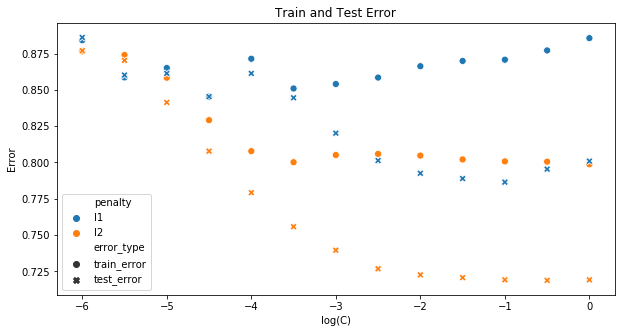

In [71]:
import seaborn as sns
fig = plt.figure(figsize = [10,5])
ax = sns.scatterplot(data = df_plot1, 
                     x = np.log10(df_plot1.C), 
                     y = 'error',
                     hue = 'penalty',
                     style= 'error_type',
                     s=50
                    )
plt.xlabel('log(C)')
plt.ylabel('Error')
plt.title('Train and Test Error')
plt.show()

Text(0.5, 1.0, 'Precision and Recall')

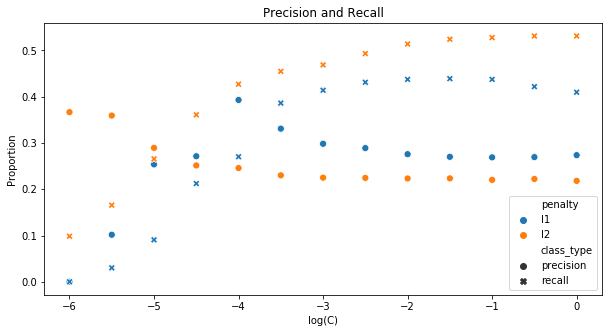

In [72]:
fig = plt.figure(figsize = [10,5])
ax = sns.scatterplot(data = df_plot2, 
                     x = np.log10(df_plot2.C), 
                     y = 'classification', 
                     hue = 'penalty',
                     style = 'class_type',
                     s = 50
                    )
plt.xlabel('log(C)')
plt.ylabel('Proportion')
plt.title('Precision and Recall')

In [73]:
#Train model with optimal parameters and apply to test set
model = LogisticRegression(solver = 'liblinear', C = 5e-2, penalty = 'l2')
model.fit(X_train,
          y_train,
          sample_weight = train_weight)
y_predict = model.predict(X_test)

print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

              precision    recall  f1-score   support

       False       0.92      0.77      0.84      6856
        True       0.22      0.50      0.30       900

   micro avg       0.74      0.74      0.74      7756
   macro avg       0.57      0.63      0.57      7756
weighted avg       0.84      0.74      0.78      7756

[[5271 1585]
 [ 453  447]]


In [109]:
coef_rank = np.argsort(model.coef_[0,:])
ten_neg = coef_rank[:10]
ten_pos = coef_rank[-10:]
print('The top ten factors increasing dropout likelihood are:')
for pos in ten_pos:
    cat = df.columns[pos].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])
print('\n')
print('The top ten factors decreasing dropout likelihood are:')
for neg in ten_neg:
    cat = df.columns[neg].split('_')
    print(' '.join(number_labels[cat[0]]['desc'].split()[2:]),'-',cat[1])

The top ten factors increasing dropout likelihood are:
Hours spent hanging out with friends on typical schoolday - nan
Importance of placement tests for 10th to 12th grade math placement - nan
Math teachers in this department share and discuss student work - 4.0
Parent 2's major for Bachelor's degree 2-digit CIP code - 24.0
Grade level 9th grader was placed in when started school in U.S. - 1.0
9th grader thinks even if he/she studies he/she won't get into college - nan
Science teacher's major for BA/BS 2-digit CIP - 52.0
How often 9th grader speaks first language with friends - 3.0
Parent 2's major for Bachelor's degree 2-digit CIP code - 51.0
Whether 9th grader has ever stopped attending school for a month or more - 1.0


The top ten factors decreasing dropout likelihood are:
Whether 9th grader has ever stopped attending school for a month or more - 0.0
Science teacher's emphasis on preparation for further science study - 2.0
How often 9th grader speaks first language with friends - 2